#TP2 Aprendizaje Automático II


# Problema 1

# Instalación de dependencias y configuración del entorno

In [ ]:
!pip install -q tensorflow tensorflow-datasets librosa

import os
import pathlib
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

# Carga del dataset

In [ ]:
# Carga el dataset spoken_digit
ds, ds_info = tfds.load('spoken_digit', split='train', with_info=True, as_supervised=True)

# Variables útiles
num_examples = ds_info.splits['train'].num_examples
label_names = ds_info.features['label'].names

print(f"Dataset cargado: {ds_info.name}")
print(f"Número total de ejemplos: {num_examples}")
print(f"Etiquetas disponibles: {label_names}")

Dataset cargado: spoken_digit
Número total de ejemplos: 2500
Etiquetas disponibles: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Los clips de audio del conjunto de datos se almacenan en diez carpetas correspondientes a cada dígito

In [ ]:
# Obtener las etiquetas (comandos) directamente desde los metadatos del dataset
commands = np.array(ds_info.features['label'].names)
print('Commands:', commands)

Commands: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [ ]:
# Convertir dataset completo a lista para dividirlo
ds = ds.shuffle(2500, seed=0)

# Definir fracción de validación
val_split = 0.2
val_size = int(2500 * val_split)
train_size = 2500 - val_size

# Separar en entrenamiento y validación
train_ds = ds.take(train_size).batch(64)
val_ds = ds.skip(train_size).batch(64)

# Obtener nombres de etiquetas
label_names = np.array(ds_info.features['label'].names)

print("label names:", label_names)

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


# Extracción y preprocesamiento de datos

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Observamos que cada elemento del dataset es una tupla con dos tensores:

Primer tensor: shape=(None, None). Es una matriz de tamaño variable en ambas dimensiones.

Segundo tensor: shape=(None,). Es un vector de tamaño variable.

Normalizamos la longitud de cada señal de audio a un tamaño fijo.

In [ ]:
DESIRED_LENGTH = 6000

def pad_or_trim(audio, label):
  audio = tf.cast(audio, tf.float32)
  audio = audio[:DESIRED_LENGTH]
  zero_padding = tf.zeros([DESIRED_LENGTH] - tf.shape(audio), dtype=tf.float32)
  audio = tf.concat([audio, zero_padding], 0)
  return audio, label


ds = ds.shuffle(2500, seed=0) # Mezcla aleatoriamente los datos, útil para evitar sesgo en el entrenamiento.
ds = ds.map(pad_or_trim, num_parallel_calls=tf.data.AUTOTUNE) # Aplica la función de padding/recorte a cada muestra.

train_ds = ds.take(2000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = ds.skip(2000).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 6000)
(64,)


El primer tensor (example_audio) es un batch de 64 ejemplos, cada uno con 6000 muestras (audios ya normalizados en longitud y tipo).

El segundo tensor (example_labels) es un vector de 64 etiquetas, una por cada audio en el batch.



# Visualización

Mostramos la forma de onda de un archivo de audio individual, después de ser procesado y normalizado a 6000 muestras.

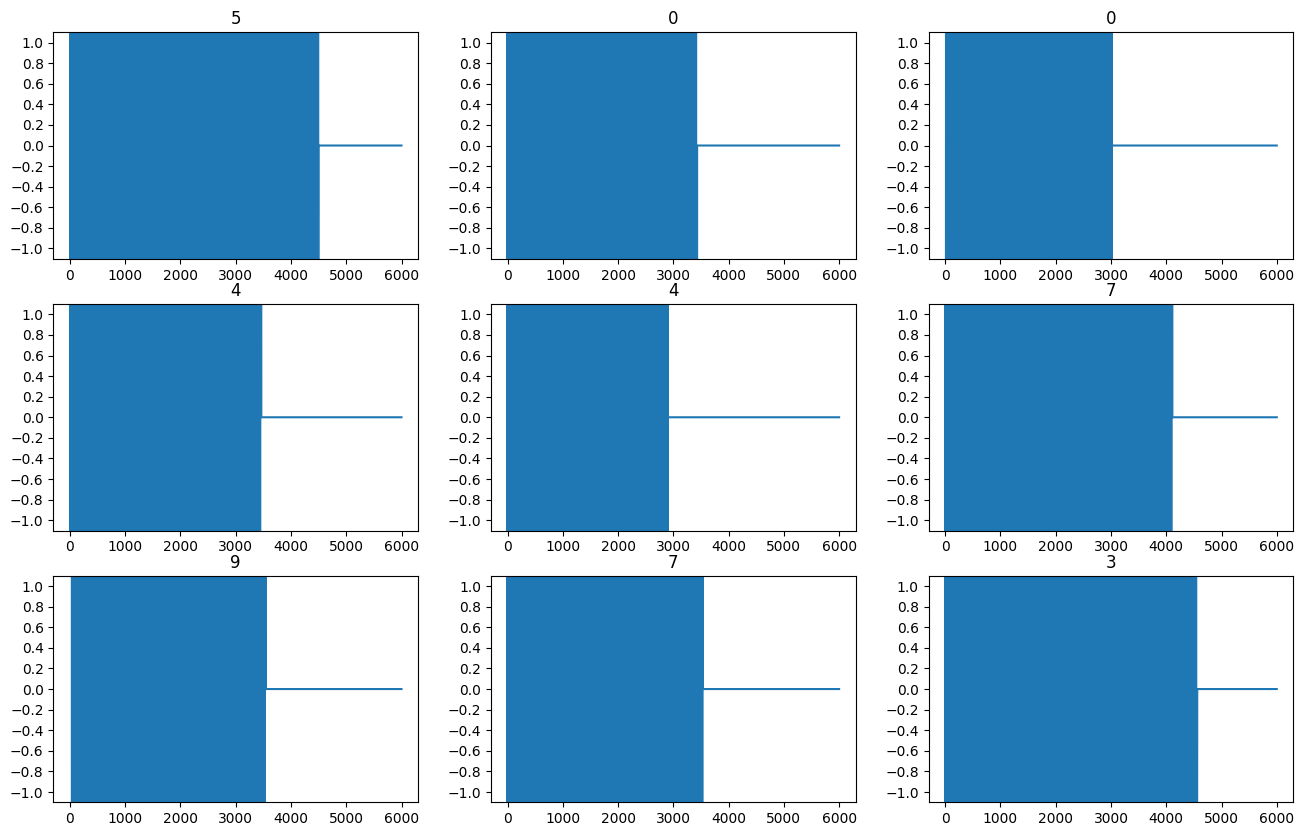

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

La porción activa de cada onda se concentra en los primeros 2,000 a 4,500 samples; el resto es padding en cero. En otras palabras, solo una parte de la señal contiene información útil (zona azul); el resto es una línea plana en 0.

Esto confirma que los audios originales son más cortos que 6000 muestras, y que la mayor parte de cada señal está “rellenada” con ceros (silencio) al final, debido a la función pad_or_trim.

Observamos que todos los audios tienen la misma longitud, y los audios cortos se completan correctamente con ceros.

La visualización confirma que la mayoría de las muestras de audio son mucho más cortas que el tamaño objetivo y que el padding no introduce valores fuera del rango [-1, 1].

# Convertir formas de onda a espectrogramas

In [ ]:
def get_spectrogram(waveform):
  # Convierte la onda en un espectrograma mediante una STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  # Obtiene la magnitud de la STFT.
  spectrogram = tf.abs(spectrogram)

  # Agrega una dimensión de `canales`, para que el espectrograma pueda usarse
  # como entrada similar a una imagen en capas convolucionales (las cuales esperan
  # forma (`batch_size`, `altura`, `ancho`, `canales`)).
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

Imprimimos las formas de uno de los ejemplos y reproducimos el audio original.

In [ ]:
for i in range(5):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: 5
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 0
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 0
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 4
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 4
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Confirmamos que:

Todas las ondas de audio están correctamente normalizadas a 6000 muestras.

La conversión a espectrograma genera tensores de forma consistente ((124 (tiempo) × 129 (frecuencias) × 1 (canal)) para todos los ejemplos).

Las etiquetas y los datos de audio están correctamente alineados.

Es posible reproducir los audios para auditoría manual.



Definimos una función para mostrar el espectrograma

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Graficamos formas de onda y sus espectrogramas

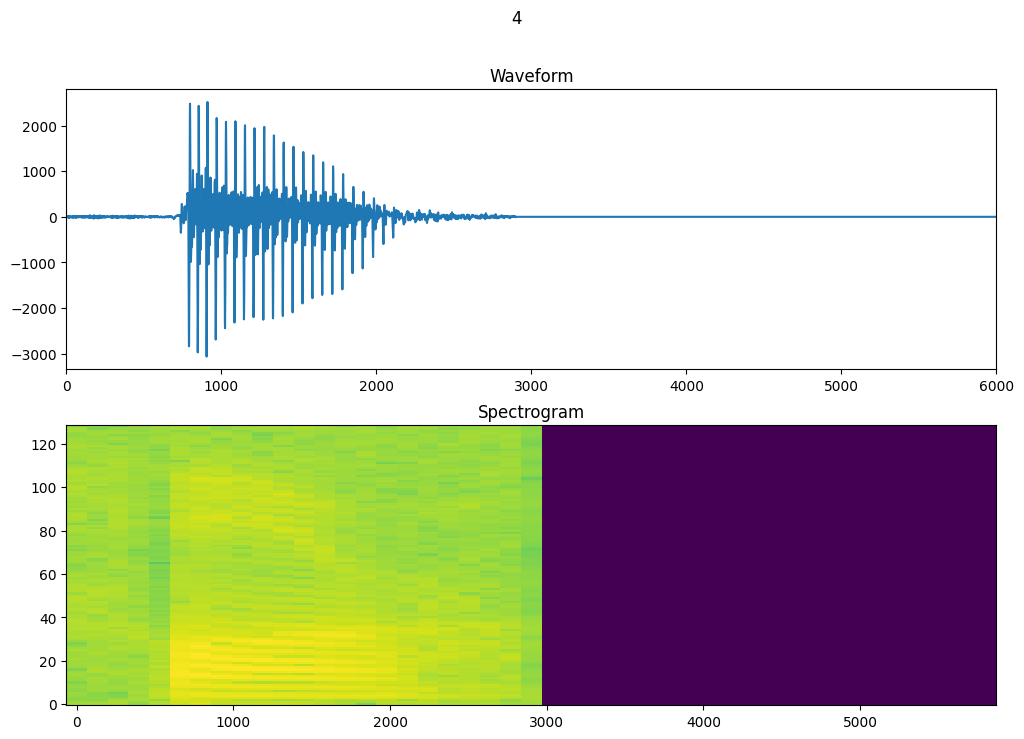

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 6000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Forma de onda (Waveform): No hay cortes abruptos, todo el contenido útil de la señal está incluido y el padding se visualiza claramente como línea plana.

Espectrograma: La actividad (colores) sólo aparece en la porción izquierda del espectrograma (hasta ~3,000). El resto es completamente negro/violeta, reflejando el padding.


Ahora creamos un dataset de espectrogramas utilizando la función definida

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Examinar el espectrograma para distintos ejemplos del dataset

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

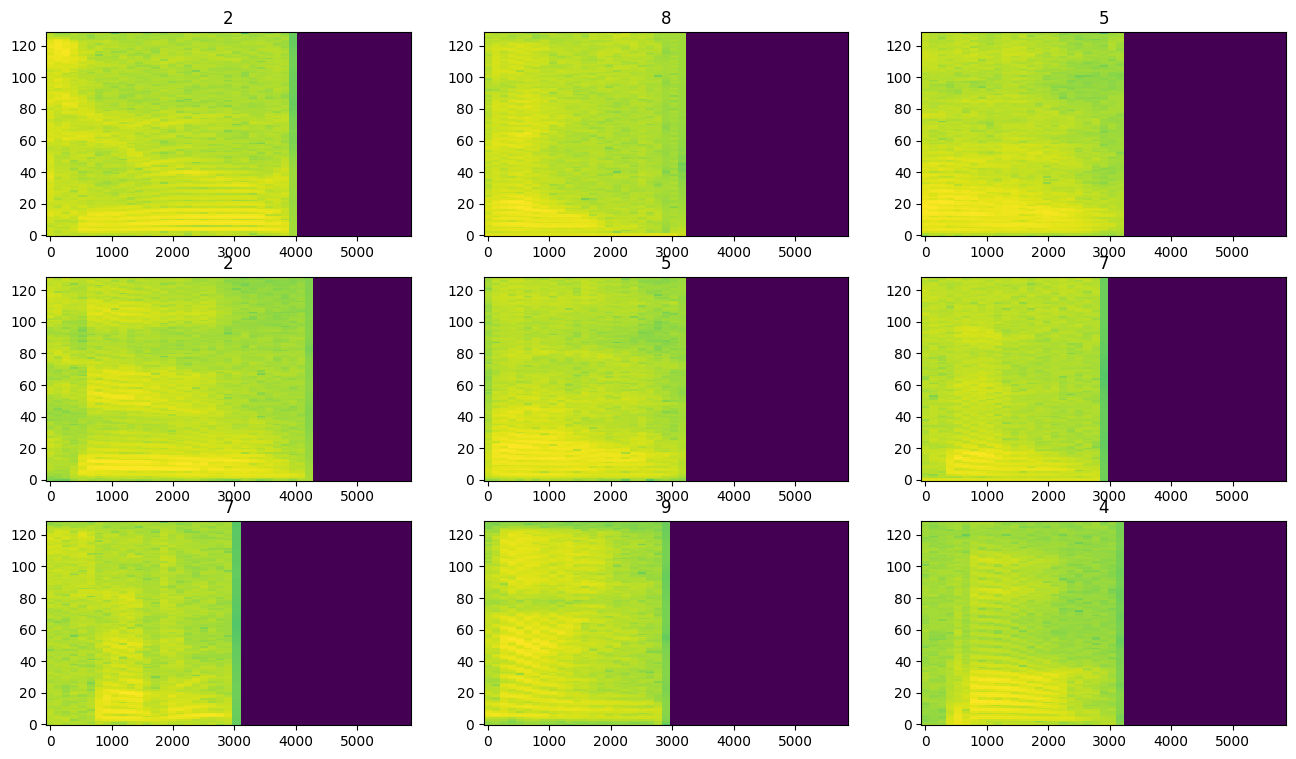

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Observamos que el padding es consistente y ocupa menos de la mitad del espectrograma, mostrando que la longitud elegida es eficiente: no hay exceso de ceros, pero tampoco recorte de la señal útil. Las diferencias entre espectrogramas permiten al modelo distinguir entre las diferentes etiquetas.

Se distinguen varias clases diferentes en el batch, lo que permite verificar visualmente que el pipeline de preprocesamiento está aplicando correctamente las transformaciones y alineando datos con sus etiquetas.

# Modelo CNN

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.summary()

Input shape: (45, 129, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Entrenamiento

Entrenamos durante 50 epochs con early stopping  (para evitar overfitting)

In [ ]:
EPOCHS = 50
cnn_history = cnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 491ms/step - accuracy: 0.2957 - loss: 2.0054 - val_accuracy: 0.6880 - val_loss: 1.1823
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.5680 - loss: 1.2566 - val_accuracy: 0.8120 - val_loss: 0.7848
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.6999 - loss: 0.8954 - val_accuracy: 0.8860 - val_loss: 0.5706
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - accuracy: 0.7798 - loss: 0.6831 - val_accuracy: 0.9220 - val_loss: 0.3949
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.8277 - loss: 0.5395 - val_accuracy: 0.9400 - val_loss: 0.3255
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.8857 - loss: 0.4003 - val_accuracy: 0.9420 - val_loss: 0.2543
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.8890 - loss: 0.3388 - val_accuracy: 0.9600 - val_loss: 0.1732
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.9190 - loss: 0.2543 - val_accuracy

## Visualización

Text(0, 0.5, 'Accuracy [%]')

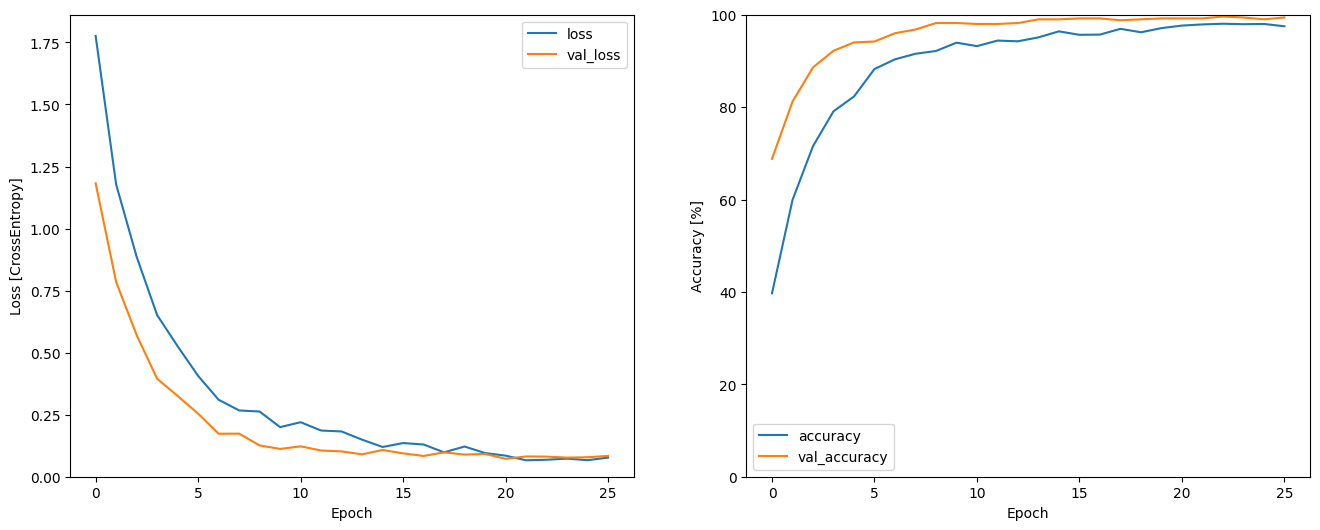

In [ ]:
metrics = cnn_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(cnn_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(cnn_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

No hay señales de sobreajuste:

La validación nunca se despega ni se degrada respecto al entrenamiento.

La precisión y la pérdida son incluso mejores en validación, lo cual es poco frecuente pero puede darse si el set de validación es ligeramente más fácil o más balanceado que el de entrenamiento.

El modelo aprendió muy rápido y eficientemente:

Converge a excelente desempeño en pocas épocas.

La elección de arquitectura y preprocesamiento está bien alineada con el problema.

## Métricas

In [ ]:
y_pred_cnn = cnn_model.predict(val_spectrogram_ds)
y_pred_cnn = tf.argmax(y_pred_cnn, axis=1)
y_true_cnn = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


In [ ]:
print(classification_report(y_true_cnn, y_pred_cnn, target_names=[str(l) for l in label_names]))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       1.00      1.00      1.00        54
           2       1.00      0.98      0.99        48
           3       0.97      0.97      0.97        39
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        57
           6       1.00      1.00      1.00        52
           7       1.00      1.00      1.00        47
           8       1.00      1.00      1.00        59
           9       0.96      1.00      0.98        45

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



Desempeño global sobresaliente:

Precisión, recall y f1-score muy altos (≥0.97 en todas las clases), con valores de 1.00 en la mayoría.

Clases más débiles:

“3” y “9” tienen un f1-score ligeramente menor (0.97 y 0.98), pero siguen siendo muy altos.

Exactitud global: 0.99 (99%)

Conclusión: El modelo CNN es muy robusto y equilibrado, sin clases problemáticas.

# Modelo RNN

In [ ]:
input_shape = (124, 129, 1)   # Sin el batch size
num_labels = 10

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))

rnn_model = models.Sequential([
    layers.Input(shape=input_shape),       # (124, 129, 1)
    layers.Resizing(64, 64),               # (64, 64, 1)
    norm_layer,
    layers.Reshape((64, 64)),              # (64, 64) para LSTM (timesteps, features)
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 64, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,821 (905.55 KB)

 Trainable params: 231,818 (905.54 KB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo

In [ ]:
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Entrenamiento

In [ ]:
rnn_history = rnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 324ms/step - accuracy: 0.2564 - loss: 2.1110 - val_accuracy: 0.6780 - val_loss: 1.1410
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.5936 - loss: 1.1454 - val_accuracy: 0.7320 - val_loss: 0.7310
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.7392 - loss: 0.7717 - val_accuracy: 0.8920 - val_loss: 0.3618
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.8456 - loss: 0.4728 - val_accuracy: 0.8740 - val_loss: 0.3506
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.8625 - loss: 0.4412 - val_accuracy: 0.9480 - val_loss: 0.1985
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9253 - loss: 0.2444 - val_accuracy: 0.9560 - val_loss: 0.1791
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.9405 - loss: 0.2068 - val_accuracy: 0.9700 - val_loss: 0.1166
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9451 - loss: 0.1665 - val_accuracy:

## Visualización

Text(0, 0.5, 'Accuracy [%]')

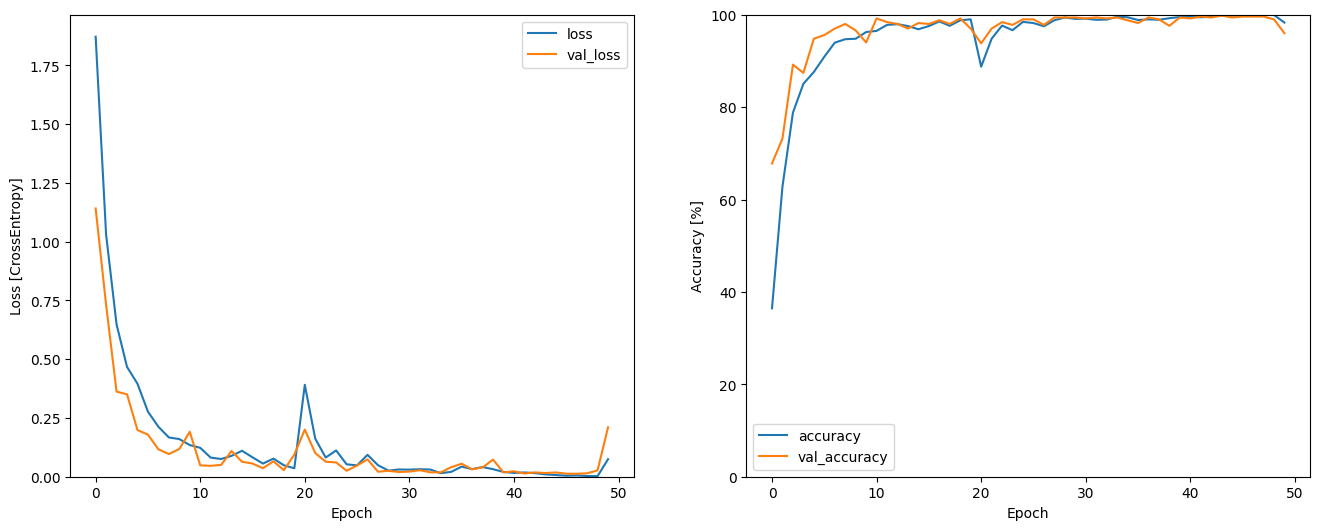

In [ ]:
metrics = rnn_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(rnn_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(rnn_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Hay pequeñas oscilaciones o “picos” en algunas épocas (por ejemplo, cerca de la época 20), tanto en entrenamiento como en validación. Esto puede deberse a batches atípicos, alta tasa de aprendizaje, o ruido en los datos.

El modelo generaliza bien: No hay indicios de sobreajuste ni subajuste a lo largo de las 50 épocas. Las oscilaciones son menores y no afectan a la precisión final.

Las curvas de precisión son altas, lo que ratifica que la arquitectura y el preprocesamiento están funcionando correctamente.



## Métricas

In [ ]:
y_pred_rnn = rnn_model.predict(val_spectrogram_ds)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)
y_true_rnn = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step


In [ ]:
print(classification_report(y_true_rnn, y_pred_rnn, target_names=[str(l) for l in label_names]))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        42
           1       1.00      0.98      0.99        54
           2       1.00      1.00      1.00        48
           3       0.95      0.97      0.96        39
           4       0.92      1.00      0.96        57
           5       1.00      0.98      0.99        57
           6       0.83      1.00      0.90        52
           7       0.95      0.81      0.87        47
           8       1.00      0.98      0.99        59
           9       1.00      1.00      1.00        45

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



Desempeño alto, pero con debilidades puntuales:

Clases con menor recall:

“0” (recall 0.83), “7” (recall 0.81), y “6” (precisión 0.83), lo que coincide con las confusiones vistas en la matriz de confusión.

Clases excelentes:

“2”, “9” y “5” mantienen f1-score de 0.99 o 1.00.

Exactitud global: 0.96 (96%)

Conclusión:

Aunque la RNN generaliza bien, tiene problemas para distinguir algunos casos de “0”, “6” y “7”, lo que baja el recall y el f1-score en esas clases.

# Evaluación y comparación de modelos

## Precisión

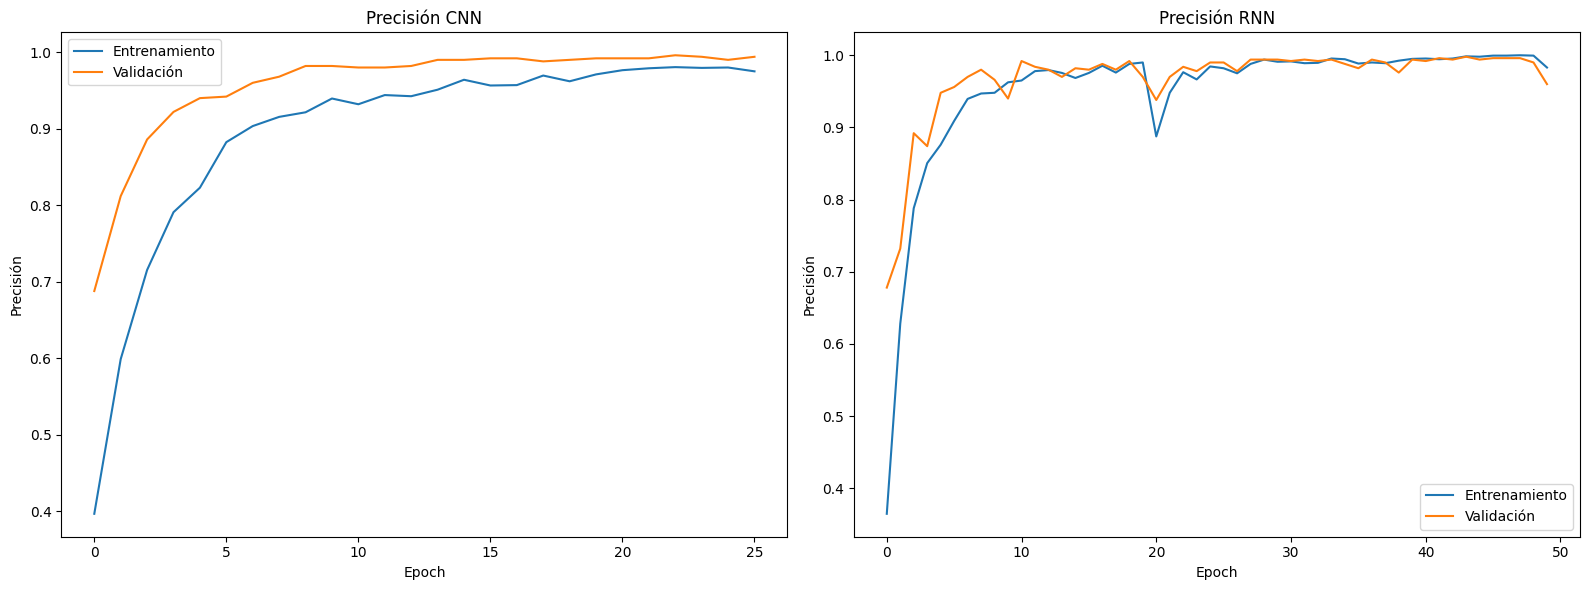

In [ ]:
def plot_history_subplot(history, title, ax):
    ax.plot(history.history['accuracy'], label='Entrenamiento')
    ax.plot(history.history['val_accuracy'], label='Validación')
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Precisión")
    ax.legend()

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_history_subplot(cnn_history, "Precisión CNN", axes[0])
plot_history_subplot(rnn_history, "Precisión RNN", axes[1])

plt.tight_layout()
plt.show()

Ambos modelos logran alta precisión en entrenamiento y validación, con generalización adecuada (sin sobreajuste).

La RNN converge más rápido y alcanza valores máximos de precisión antes que la CNN, aunque presenta pequeñas oscilaciones, propias de su naturaleza secuencial.

La CNN requiere más épocas para estabilizar la precisión máxima, pero es más estable y predecible en el aprendizaje.

Ambos modelos son adecuados para el problema, con desempeño final similar y excelente generalización.

## Matrices de confusión

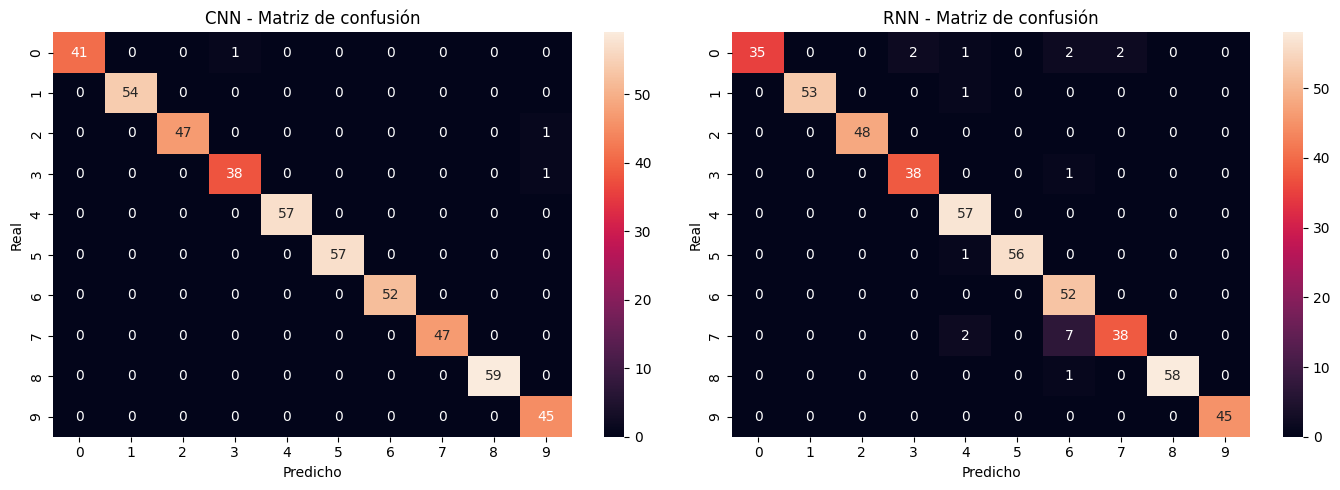

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_names, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")

# Asegura los nombres de las etiquetas
try:
    label_names
except NameError:
    label_names = [str(i) for i in range(np.max(y_true_cnn)+1)]

# Graficar lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_confusion_matrix(y_true_cnn, y_pred_cnn, label_names, "CNN - Matriz de confusión", axes[0])
plot_confusion_matrix(y_true_rnn, y_pred_rnn, label_names, "RNN - Matriz de confusión", axes[1])

plt.tight_layout()
plt.show()

La CNN presenta un desempeño más robusto y parejo entre clases, con muy pocos errores y mejor discriminación global.

La RNN, aunque alcanza muy buena precisión general, tiene más errores de confusión en ciertas clases, en especial “0” y “7”.

En problemas de clasificación multiclase con espectrogramas, la CNN resulta ser más confiable y estable en este experimento, especialmente cuando el objetivo es minimizar el número de errores por clase.



# Conclusiones

Ambos modelos muestran un desempeño general alto en la tarea de clasificación de señales de audio, alcanzando precisiones globales del 99% (CNN) y 96% (RNN) sobre el conjunto de validación.

La arquitectura CNN demuestra una superioridad clara en estabilidad y discriminación entre clases:

Presenta métricas casi perfectas (f1-score ≥ 0.97) en todas las clases, sin evidencia de clases problemáticas. La matriz de confusión confirma que los errores son muy aislados y no sistemáticos.

La RNN también logra buenos resultados, pero exhibe debilidades puntuales:

Se observan confusiones especialmente entre las clases “0”, “6” y “7”, lo que reduce el recall y el f1-score en esas categorías.Esto sugiere que la RNN, al menos con esta arquitectura y preprocesamiento, es más sensible a variaciones en ciertas clases.

No hay signos de sobreajuste en ninguno de los modelos:
Las curvas de pérdida y precisión en entrenamiento y validación se mantienen cercanas y estables durante todas las épocas, lo que valida un preprocesamiento adecuado y un pipeline robusto.

Conclusión final:

Si el objetivo es máxima robustez y precisión global, la CNN es la arquitectura recomendada para este problema.

La RNN puede ser una opción válida, pero sería necesario ajustar hiperparámetros, introducir regularización o enriquecer el preprocesamiento para superar sus debilidades puntuales.